In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token="",
    channel="ibm_quantum_platform",
    url="https://cloud.ibm.com/quantum-api",
    instance="",
    overwrite=True
)

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum_platform")
print("Backends:")
print(service.backends())

Backends:
[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]



===== SYSTEM INFO =====
CPU: x86_64
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


===== TOP-3 FEATURES =====
• α (Absorption cm^-1)
• κ (Extinction coeff)
• Energy (eV)

===== Classical SVM =====
{'train': 0.9913194444444444, 'val': 0.9861111111111112, 'test': 0.9826989619377162}

===== QSVM (Simulator) =====
{'train': 0.7213541666666666, 'val': 0.71875, 'test': 0.7197231833910035}

===== QSVM (IBM Hardware) =====
Using backend: ibm_fez
Hardware QSVM accuracy (train slice): 1.0
[SAVED] Hardware artifacts → /home/udavid/Quantum/Qiskit_Advocate/QAMP_2025/Q-UCSpec_Github/Q-UCSpec-main-QML/data/../artifacts_qsvm_hw

===== FINAL SUMMARY =====
SVM : {'train': 0.9913194444444444, 'val': 0.9861111111111112, 'test': 0.9826989619377162}
QSVM_sim : {'train': 0.7213541666666666, 'val': 0.71875, 'test': 0.7197231833910035}
QSVM_ibm : {'train': 1.0}


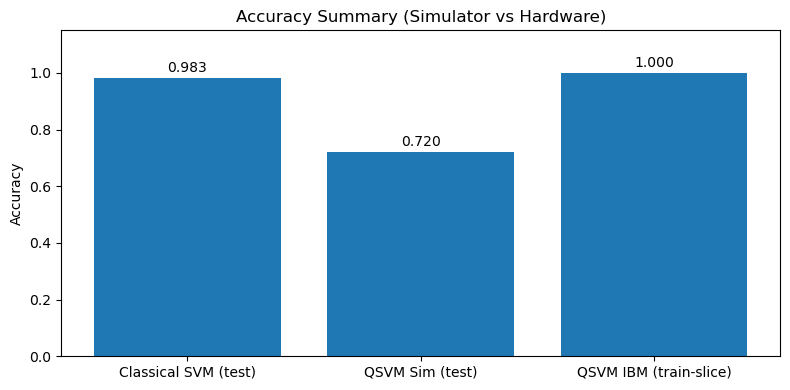

In [17]:
# ============================================================
# Quantum SVM: Classical vs Simulator vs IBM Quantum Hardware
# Qiskit Runtime "V2" / Sampler(mode=backend)
# Author: Q-UCSpec
# ============================================================

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import platform
import subprocess

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit.transpiler import generate_preset_pass_manager

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# ============================================================
# GLOBAL METRICS
# ============================================================

ACCURACY_RESULTS = {}
RUNTIME_RESULTS = {}

# ============================================================
# HARDWARE INFO
# ============================================================

def print_hardware_info():
    print("\n===== SYSTEM INFO =====")
    print("CPU:", platform.processor() or platform.machine())
    try:
        gpu = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"]
        ).decode().strip()
        print("GPU:", gpu)
    except Exception:
        print("GPU: None")
    print("=======================\n")

# ============================================================
# CONFIG
# ============================================================

DATA_DIR = "/home/udavid/Quantum/Qiskit_Advocate/QAMP_2025/Q-UCSpec_Github/Q-UCSpec-main-QML/data"

FEATURES_ALL = [
    "Energy (eV)",
    "OscStrength",
    "Normalized f",
    "ε₁ (Real dielectric)",
    "ε₂ (Imag dielectric)",
    "n (Refractive index)",
    "κ (Extinction coeff)",
    "α (Absorption cm^-1)",
]

SEED = 42

# Simulator QSVM subset (keeps QSVC fast)
MAX_QSVM_SAMPLES = 50

# Hardware constraints
HARDWARE_BACKEND_NAME = "ibm_fez"
HARDWARE_TRAIN_POINTS = 8      # keep small to fit free minutes
HARDWARE_SHOTS = 512
HARDWARE_OPT_LEVEL = 2

# Optional: save artifacts
SAVE_ARTIFACTS = True
ARTIFACT_DIR = os.path.join(DATA_DIR, "..", "artifacts_qsvm_hw")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# ============================================================
# DATASET + FEATURE SELECTION
# ============================================================

def load_dataset_top3():
    caf2 = pd.read_csv(os.path.join(DATA_DIR, "caf2_qml_full_descriptors.csv"))
    er   = pd.read_csv(os.path.join(DATA_DIR, "caf2_er_qml_full_descriptors.csv"))

    caf2["label"] = 0
    er["label"] = 1

    df = pd.concat([caf2, er], ignore_index=True)

    # Keep only the feature columns + label
    X = df[FEATURES_ALL].values
    y = df["label"].values

    # Split
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=SEED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
    )

    # Robust scaling: Yeo-Johnson handles zeros/negatives
    #scaler = PowerTransformer(method="yeo-johnson", standardize=True)
    scaler = PowerTransformer(method="box-cox", standardize=True)
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Rank features with linear SVM coefficients
    svm_lin = SVC(kernel="linear")
    svm_lin.fit(X_train, y_train)

    idx = np.argsort(np.abs(svm_lin.coef_[0]))[-3:][::-1]
    top_features = [FEATURES_ALL[i] for i in idx]

    print("\n===== TOP-3 FEATURES =====")
    for f in top_features:
        print("•", f)

    return (
        X_train[:, idx],
        X_val[:, idx],
        X_test[:, idx],
        y_train,
        y_val,
        y_test,
        top_features,
        scaler,
        idx,
    )

# ============================================================
# CLASSICAL BASELINE
# ============================================================

def classical_svm(X_train, X_val, X_test, y_train, y_val, y_test):
    print("\n===== Classical SVM =====")

    t0 = time.perf_counter()
    clf = SVC(kernel="rbf")
    clf.fit(X_train, y_train)
    t1 = time.perf_counter()

    acc = {
        "train": clf.score(X_train, y_train),
        "val":   clf.score(X_val, y_val),
        "test":  clf.score(X_test, y_test),
    }

    print(acc)
    ACCURACY_RESULTS["SVM"] = acc
    RUNTIME_RESULTS["SVM_fit_s"] = t1 - t0
    return clf

# ============================================================
# QSVM (SIMULATOR)
# ============================================================

def qsvm_simulator(X_train, X_val, X_test, y_train, y_val, y_test):
    print("\n===== QSVM (Simulator) =====")

    # Subsample for QSVC fitting speed
    idx = np.random.choice(len(X_train), size=min(MAX_QSVM_SAMPLES, len(X_train)), replace=False)
    Xq, yq = X_train[idx], y_train[idx]

    fmap = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=1)
    kernel = FidelityQuantumKernel(feature_map=fmap)
    qsvc = QSVC(quantum_kernel=kernel)

    t0 = time.perf_counter()
    qsvc.fit(Xq, yq)
    t1 = time.perf_counter()

    acc = {
        "train": accuracy_score(y_train, qsvc.predict(X_train)),
        "val":   accuracy_score(y_val,   qsvc.predict(X_val)),
        "test":  accuracy_score(y_test,  qsvc.predict(X_test)),
    }

    print(acc)
    ACCURACY_RESULTS["QSVM_sim"] = acc
    RUNTIME_RESULTS["QSVM_sim_fit_s"] = t1 - t0
    return qsvc

# ============================================================
# QSVM (IBM QUANTUM HARDWARE) — minimal, reliable
#   - Build a tiny hardware Gram matrix K (NxN)
#   - Train SVC(kernel="precomputed") on K
#   - Report train accuracy on that slice
# ============================================================

def qsvm_ibm_hardware(X_train, y_train):
    print("\n===== QSVM (IBM Hardware) =====")

    # Tiny slice to fit free minutes
    Xq = X_train[:HARDWARE_TRAIN_POINTS]
    yq = y_train[:HARDWARE_TRAIN_POINTS]

    # Connect (assumes you already saved account)
    service = QiskitRuntimeService(channel="ibm_quantum_platform")
    backend = service.backend(HARDWARE_BACKEND_NAME)
    print("Using backend:", backend.name)

    # Feature map + sampler
    fmap = ZZFeatureMap(feature_dimension=Xq.shape[1], reps=1, entanglement="full")
    sampler = Sampler(mode=backend)

    # Pass manager (required for ISA compliance)
    pm = generate_preset_pass_manager(
        optimization_level=HARDWARE_OPT_LEVEL,
        backend=backend
    )

    circuits = []
    index_map = []  # reconstruct the Gram matrix
    K = np.zeros((HARDWARE_TRAIN_POINTS, HARDWARE_TRAIN_POINTS)) # Gram matrix

    # Inner product kernel with ZZFeatureMap 
    for i in range(0, HARDWARE_TRAIN_POINTS):
        for j in range(i + 1, HARDWARE_TRAIN_POINTS):
            # Build circuit: U(x1) then U(x2)
            qc = QuantumCircuit(fmap.num_qubits)
            qc.compose(fmap.assign_parameters(Xq[i]), inplace=True)
            qc.compose(fmap.assign_parameters(Xq[j]), inplace=True)
            qc.measure_all()
            # ISA compliant circuit
            qc = pm.run(qc)
            # Save circuit and index map in arrays
            circuits.append(qc)
            index_map.append((i, j))
        # Fill in on-diagonal elements with 1 (since this is an inner product)
        K[i, i] = 1.0

    # Execute  all circuits with a single job (more efficient)
    t0 = time.perf_counter()
    job = sampler.run(circuits, shots=HARDWARE_SHOTS)
    result = job.result()
    t1 = time.perf_counter()

    # Reconstruct the Gram matrix
    for k, (i, j) in enumerate(index_map):
        counts = result[k].data.meas.get_counts()
        # Fidelity proxy: P(|00..0>)
        # Assign the probability of the 0 state to the kernel matrix and the transposed element (since this is an inner product)
        K[i, j] = counts.get("0" * fmap.num_qubits, 0) / HARDWARE_SHOTS
        K[j, i] = counts.get("0" * fmap.num_qubits, 0) / HARDWARE_SHOTS

    # Precomputed-kernel SVM on hardware slice
    clf = SVC(kernel="precomputed")
    clf.fit(K, yq)
    acc_train = float(np.mean(clf.predict(K) == yq))

    print("Hardware QSVM accuracy (train slice):", acc_train)

    ACCURACY_RESULTS["QSVM_ibm"] = {"train": acc_train}
    RUNTIME_RESULTS["QSVM_ibm_kernel_s"] = t1 - t0

    # Save artifacts (so you can reuse without burning minutes)
    if SAVE_ARTIFACTS:
        np.save(os.path.join(ARTIFACT_DIR, "K_hw.npy"), K)
        np.save(os.path.join(ARTIFACT_DIR, "y_hw.npy"), yq)
        meta = {
            "backend": backend.name,
            "shots": HARDWARE_SHOTS,
            "train_points": int(len(Xq)),
            "feature_dim": int(fmap.num_qubits),
            "opt_level": int(HARDWARE_OPT_LEVEL),
        }
        with open(os.path.join(ARTIFACT_DIR, "hw_meta.json"), "w") as f:
            import json
            json.dump(meta, f, indent=2)
        print(f"[SAVED] Hardware artifacts → {ARTIFACT_DIR}")

    return clf, K, yq

# ============================================================
# OPTIONAL: quick bar plot of test accuracies we have
# ============================================================

def plot_accuracy_summary():
    labels = []
    values = []

    if "SVM" in ACCURACY_RESULTS:
        labels.append("Classical SVM (test)")
        values.append(ACCURACY_RESULTS["SVM"]["test"])
    if "QSVM_sim" in ACCURACY_RESULTS:
        labels.append("QSVM Sim (test)")
        values.append(ACCURACY_RESULTS["QSVM_sim"]["test"])
    if "QSVM_ibm" in ACCURACY_RESULTS:
        labels.append("QSVM IBM (train-slice)")
        values.append(ACCURACY_RESULTS["QSVM_ibm"]["train"])

    if not labels:
        return

    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels, values)
    plt.ylim(0, 1.15)
    plt.ylabel("Accuracy")
    plt.title("Accuracy Summary (Simulator vs Hardware)")
    for b, v in zip(bars, values):
        plt.text(b.get_x() + b.get_width()/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

# ============================================================
# MAIN PIPELINE
# ============================================================

def main():
    np.random.seed(SEED)
    print_hardware_info()

    X_train, X_val, X_test, y_train, y_val, y_test, feats, scaler, feat_idx = load_dataset_top3()

    svm = classical_svm(X_train, X_val, X_test, y_train, y_val, y_test)
    qsvc_sim = qsvm_simulator(X_train, X_val, X_test, y_train, y_val, y_test)

    # Hardware (may consume runtime minutes)
    qsvm_hw, K_hw, y_hw = qsvm_ibm_hardware(X_train, y_train)

    print("\n===== FINAL SUMMARY =====")
    for k, v in ACCURACY_RESULTS.items():
        print(k, ":", v)

    plot_accuracy_summary()

    # Return artifacts so your next analysis cell can use them
    return {
        "X_train": X_train, "X_val": X_val, "X_test": X_test,
        "y_train": y_train, "y_val": y_val, "y_test": y_test,
        "FEATURES": feats,
        "scaler": scaler,
        "feature_idx": feat_idx,
        "svm": svm,
        "qsvc_sim": qsvc_sim,
        "hw_pack": {
            "K_hw": K_hw,
            "y_hw": y_hw,
            "qsvm_hw": qsvm_hw,
        },
    }

if __name__ == "__main__":
    artifacts = main()

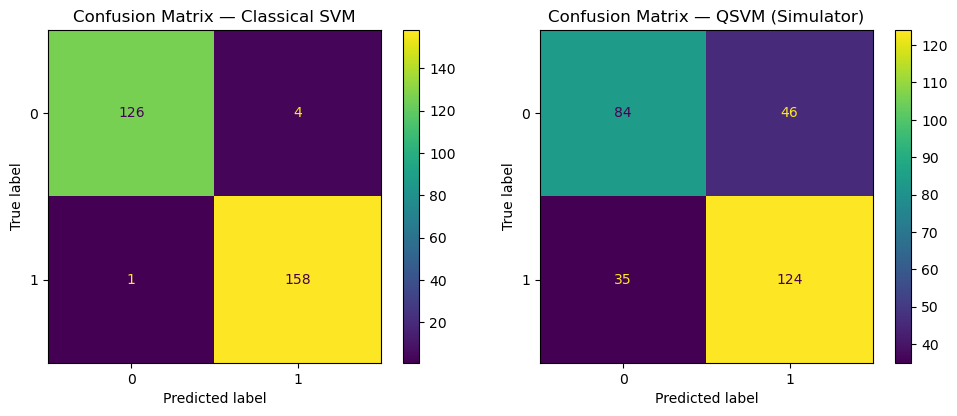


===== (1) CLASSIFICATION REPORTS (TEST) =====

--- Classical SVM ---
              precision    recall  f1-score   support

           0     0.9921    0.9692    0.9805       130
           1     0.9753    0.9937    0.9844       159

    accuracy                         0.9827       289
   macro avg     0.9837    0.9815    0.9825       289
weighted avg     0.9829    0.9827    0.9827       289


--- QSVM (Simulator) ---
              precision    recall  f1-score   support

           0     0.7059    0.6462    0.6747       130
           1     0.7294    0.7799    0.7538       159

    accuracy                         0.7197       289
   macro avg     0.7176    0.7130    0.7142       289
weighted avg     0.7188    0.7197    0.7182       289



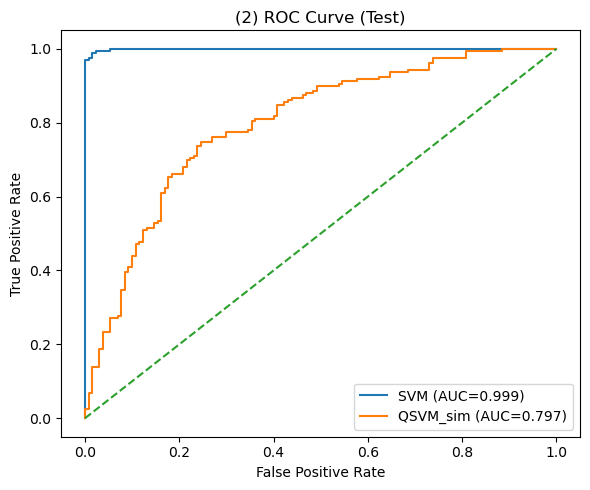

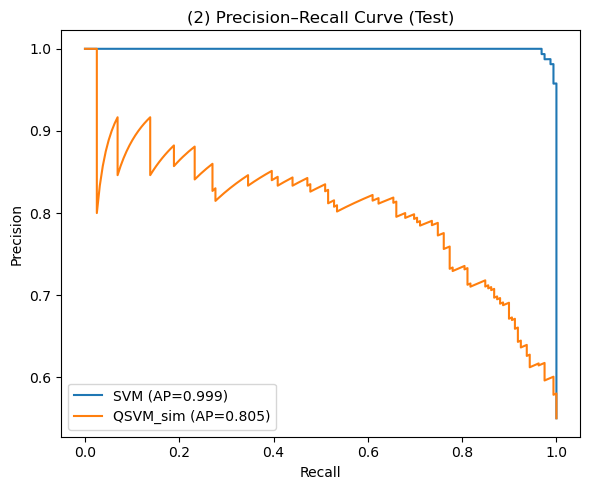


===== (3) CALIBRATION SKIPPED =====
SVM was trained without probability=True, so predict_proba is unavailable.

===== (4) PERMUTATION IMPORTANCE — Classical SVM (Test) =====
  α (Absorption cm^-1) :  0.5118 ± 0.0203
  κ (Extinction coeff) :  0.3904 ± 0.0240
           Energy (eV) :  0.2843 ± 0.0210


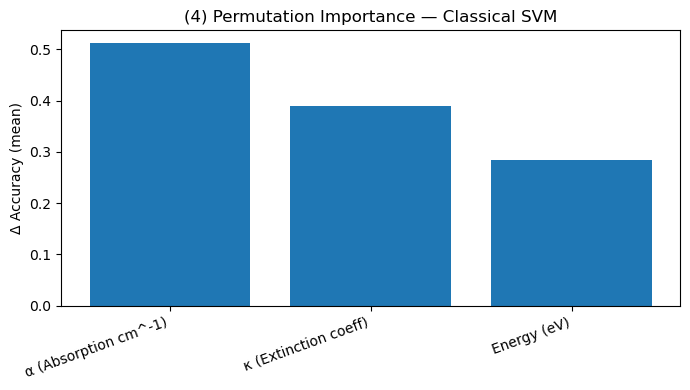


===== (5) BOOTSTRAP TEST ACCURACY (mean ± 95% CI) =====
SVM       : mean=0.9828 | 95% CI=(0.9689, 0.9965)
QSVM_sim  : mean=0.7206 | 95% CI=(0.6713, 0.7769)

[HW SLICE] QSVM_hw accuracy on its kernel slice: 1.0000


<Figure size 500x400 with 0 Axes>

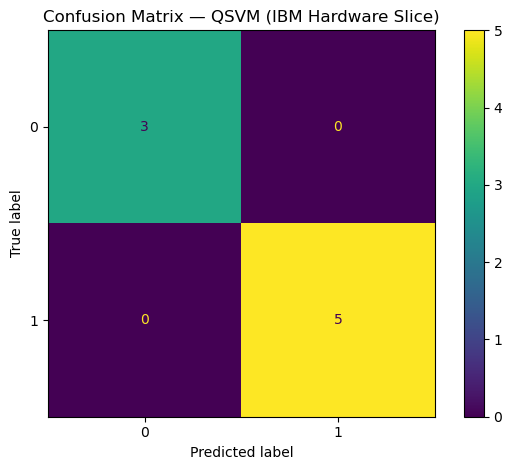

In [18]:
# ============================================================
# 5-in-1 POST-ANALYSIS PIPELINE
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

def _safe_scores(model, X):
    """Return scores for ROC/PR: prefer decision_function, else predict_proba[:,1]."""
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    return None

def _bootstrap_acc(y_true, y_pred_fn, n_boot=500, seed=0):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    accs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yt = y_true[idx]
        yp = y_pred_fn(idx)
        accs.append(np.mean(yp == yt))
    accs = np.array(accs)
    return float(accs.mean()), (float(np.quantile(accs, 0.025)), float(np.quantile(accs, 0.975)))

def run_5_analyses(
    X_train, X_val, X_test, y_train, y_val, y_test,
    FEATURES,
    svm_model,
    qsvc_sim,
    hw_pack=None,  # dict like {"K_hw": K_hw, "y_hw": y_hw, "qsvm_hw": qsvm_hw}
    n_boot=500,
):
    # -----------------------------
    # Predictions
    # -----------------------------
    yhat_svm = svm_model.predict(X_test)
    yhat_qsim = qsvc_sim.predict(X_test)

    # -----------------------------
    # (1) Confusion matrices + reports
    # -----------------------------
    fig = plt.figure(figsize=(10, 4))
    ax1 = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_svm)).plot(ax=ax1, values_format="d")
    ax1.set_title("Confusion Matrix — Classical SVM")

    ax2 = plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_qsim)).plot(ax=ax2, values_format="d")
    ax2.set_title("Confusion Matrix — QSVM (Simulator)")
    plt.tight_layout()
    plt.show()

    print("\n===== (1) CLASSIFICATION REPORTS (TEST) =====")
    print("\n--- Classical SVM ---")
    print(classification_report(y_test, yhat_svm, digits=4))
    print("\n--- QSVM (Simulator) ---")
    print(classification_report(y_test, yhat_qsim, digits=4))

    # -----------------------------
    # (2) ROC + PR curves (if scores available)
    # -----------------------------
    svm_scores = _safe_scores(svm_model, X_test)
    qsim_scores = _safe_scores(qsvc_sim, X_test)

    if (svm_scores is not None) and (qsim_scores is not None):
        fpr1, tpr1, _ = roc_curve(y_test, svm_scores)
        fpr2, tpr2, _ = roc_curve(y_test, qsim_scores)
        auc1 = auc(fpr1, tpr1)
        auc2 = auc(fpr2, tpr2)

        p1, r1, _ = precision_recall_curve(y_test, svm_scores)
        p2, r2, _ = precision_recall_curve(y_test, qsim_scores)
        ap1 = average_precision_score(y_test, svm_scores)
        ap2 = average_precision_score(y_test, qsim_scores)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr1, tpr1, label=f"SVM (AUC={auc1:.3f})")
        plt.plot(fpr2, tpr2, label=f"QSVM_sim (AUC={auc2:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("(2) ROC Curve (Test)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 5))
        plt.plot(r1, p1, label=f"SVM (AP={ap1:.3f})")
        plt.plot(r2, p2, label=f"QSVM_sim (AP={ap2:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("(2) Precision–Recall Curve (Test)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("\n===== (2) ROC/PR SKIPPED =====")
        print("No decision_function / predict_proba available for one of the models.")

    # -----------------------------
    # (3) Calibration curve (SVM only if probas exist)
    # -----------------------------
    if hasattr(svm_model, "predict_proba"):
        prob_svm = svm_model.predict_proba(X_test)[:, 1]
        frac_pos, mean_pred = calibration_curve(y_test, prob_svm, n_bins=10, strategy="uniform")

        plt.figure(figsize=(6, 5))
        plt.plot(mean_pred, frac_pos, marker="o")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        plt.title("(3) Calibration Curve — Classical SVM (Test)")
        plt.tight_layout()
        plt.show()
    else:
        print("\n===== (3) CALIBRATION SKIPPED =====")
        print("SVM was trained without probability=True, so predict_proba is unavailable.")

    # -----------------------------
    # (4) Permutation importance (SVM on test)
    # -----------------------------
    print("\n===== (4) PERMUTATION IMPORTANCE — Classical SVM (Test) =====")
    perm = permutation_importance(
        svm_model, X_test, y_test,
        n_repeats=30, random_state=0, scoring="accuracy"
    )
    imp_mean = perm.importances_mean
    imp_std  = perm.importances_std

    order = np.argsort(imp_mean)[::-1]
    for i in order:
        print(f"{FEATURES[i]:>22s} : {imp_mean[i]: .4f} ± {imp_std[i]:.4f}")

    plt.figure(figsize=(7, 4))
    plt.bar([FEATURES[i] for i in order], imp_mean[order])
    plt.ylabel("Δ Accuracy (mean)")
    plt.title("(4) Permutation Importance — Classical SVM")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # (5) Bootstrap accuracy CI (SVM vs QSVM_sim)
    # -----------------------------
    print("\n===== (5) BOOTSTRAP TEST ACCURACY (mean ± 95% CI) =====")
    y_test_arr = np.asarray(y_test)

    # precompute predictions once, then bootstrap via indexing into them
    yhat_svm_arr = np.asarray(yhat_svm)
    yhat_qsim_arr = np.asarray(yhat_qsim)

    svm_mean, svm_ci = _bootstrap_acc(
        y_test_arr,
        lambda idx: yhat_svm_arr[idx],
        n_boot=n_boot,
        seed=1
    )
    qsim_mean, qsim_ci = _bootstrap_acc(
        y_test_arr,
        lambda idx: yhat_qsim_arr[idx],
        n_boot=n_boot,
        seed=2
    )

    print(f"SVM       : mean={svm_mean:.4f} | 95% CI=({svm_ci[0]:.4f}, {svm_ci[1]:.4f})")
    print(f"QSVM_sim  : mean={qsim_mean:.4f} | 95% CI=({qsim_ci[0]:.4f}, {qsim_ci[1]:.4f})")

    # Optional: Hardware slice quick report
    if hw_pack is not None:
        K_hw = hw_pack.get("K_hw", None)
        y_hw = hw_pack.get("y_hw", None)
        qsvm_hw = hw_pack.get("qsvm_hw", None)
        if (K_hw is not None) and (y_hw is not None) and (qsvm_hw is not None):
            y_hw = np.asarray(y_hw)
            yhat_hw = qsvm_hw.predict(K_hw)
            acc_hw = float(np.mean(yhat_hw == y_hw))
            print(f"\n[HW SLICE] QSVM_hw accuracy on its kernel slice: {acc_hw:.4f}")

            plt.figure(figsize=(5, 4))
            ConfusionMatrixDisplay(confusion_matrix(y_hw, yhat_hw)).plot(values_format="d")
            plt.title("Confusion Matrix — QSVM (IBM Hardware Slice)")
            plt.tight_layout()
            plt.show()

# -----------------------------
# RUN
# -----------------------------
run_5_analyses(
    X_train=artifacts["X_train"],
    X_val=artifacts["X_val"],
    X_test=artifacts["X_test"],
    y_train=artifacts["y_train"],
    y_val=artifacts["y_val"],
    y_test=artifacts["y_test"],
    FEATURES=artifacts["FEATURES"],
    svm_model=artifacts["svm"],
    qsvc_sim=artifacts["qsvc_sim"],
    hw_pack=artifacts["hw_pack"],
    n_boot=500
)